<a href="https://colab.research.google.com/github/park-geun-hyeong/first_deeplearning_from_keras/blob/main/AutoEncoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Library Import, Data 확인

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 

from sklearn.manifold import TSNE
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.regularizers import l1


In [ ]:
df = pd.read_csv("/content/drive/MyDrive/keras_practice/Classifier/creditcard.csv")
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


0    284315
1       492
Name: Class, dtype: int64


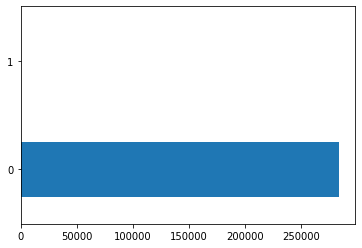

In [ ]:
df['Class'].value_counts().plot.barh()
print(df['Class'].value_counts())

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


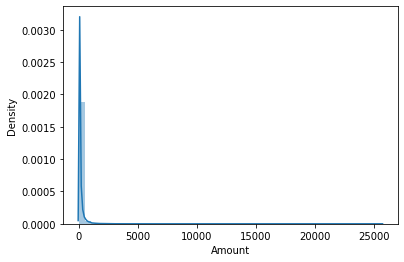

In [ ]:
sns.distplot(df['Amount'])

In [ ]:
df.isna().sum().sum()

0

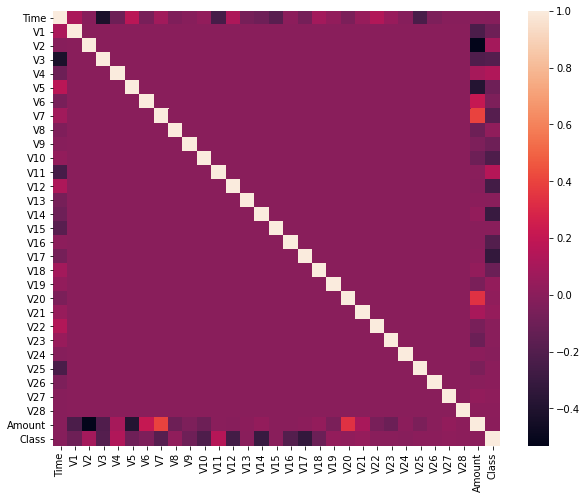

In [ ]:
df_corr = df.corr()
plt.figure(figsize=(10,8))
sns.heatmap(df_corr)

In [ ]:
vis_df = df[df['Class']==0].sample(4428)  #Class의 비율을 9:1로 축소
vis_df = vis_df.append(df[df['Class']==1])
vis_df = vis_df.reset_index(drop=True)
vis_df

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,36111.0,1.240268,0.312106,0.292313,0.702363,-0.399883,-1.075738,0.082515,-0.193303,0.065319,-0.279934,-0.103896,0.116645,0.004096,-0.241207,1.119460,0.490028,0.007798,-0.270180,-0.199591,-0.078359,-0.285189,-0.852499,0.124824,0.339678,0.205505,0.094276,-0.026082,0.031774,9.99,0
1,75715.0,1.242527,-0.892762,0.773237,-0.337467,-1.566720,-0.620356,-0.819973,-0.052801,-0.179191,0.534937,-0.920752,-0.362595,-0.363477,-0.191453,0.490149,-1.341631,0.122905,1.241526,-0.757198,-0.416012,-0.263776,-0.285215,-0.038189,0.427065,0.229353,0.941458,-0.025806,0.024171,63.33,0
2,168699.0,1.857582,-0.942441,-0.824749,-1.532983,-0.748994,-0.721118,-0.372941,-0.104586,1.755755,-0.848965,0.973835,1.823208,0.783201,0.097405,0.437717,-0.118603,-0.694038,0.284109,1.163253,0.064591,-0.130617,-0.375608,0.227927,-0.326894,-0.414213,-0.572313,0.008977,-0.033677,100.89,0
3,146176.0,1.945070,-0.092519,-2.326725,0.111179,0.760207,-1.076639,0.863503,-0.448735,0.001407,0.079888,0.708385,1.013970,0.135238,1.006014,-0.217154,-0.511617,-0.671797,0.164264,0.418680,-0.076227,0.251270,0.701590,-0.215234,-0.512962,0.587892,-0.409351,-0.049823,-0.070895,82.63,0
4,57484.0,-1.160514,0.528143,1.877109,1.529554,-0.513515,1.237876,-0.545579,1.095075,0.393751,-0.480553,-0.142653,0.627359,-1.580019,-0.025426,-1.903053,-1.164882,1.041026,-0.238133,1.706685,0.076738,-0.283684,-0.569627,-0.006193,-0.334435,-0.050342,-0.363710,0.302504,0.071282,34.90,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4915,169142.0,-1.927883,1.125653,-4.518331,1.749293,-1.566487,-2.010494,-0.882850,0.697211,-2.064945,-5.587794,2.115795,-5.417424,-1.235123,-6.665177,0.401701,-2.897825,-4.570529,-1.315147,0.391167,1.252967,0.778584,-0.319189,0.639419,-0.294885,0.537503,0.788395,0.292680,0.147968,390.00,1
4916,169347.0,1.378559,1.289381,-5.004247,1.411850,0.442581,-1.326536,-1.413170,0.248525,-1.127396,-3.232153,2.858466,-3.096915,-0.792532,-5.210141,-0.613803,-2.155297,-3.267116,-0.688505,0.737657,0.226138,0.370612,0.028234,-0.145640,-0.081049,0.521875,0.739467,0.389152,0.186637,0.76,1
4917,169351.0,-0.676143,1.126366,-2.213700,0.468308,-1.120541,-0.003346,-2.234739,1.210158,-0.652250,-3.463891,1.794969,-2.775022,-0.418950,-4.057162,-0.712616,-1.603015,-5.035326,-0.507000,0.266272,0.247968,0.751826,0.834108,0.190944,0.032070,-0.739695,0.471111,0.385107,0.194361,77.89,1
4918,169966.0,-3.113832,0.585864,-5.399730,1.817092,-0.840618,-2.943548,-2.208002,1.058733,-1.632333,-5.245984,1.933520,-5.030465,-1.127455,-6.416628,0.141237,-2.549498,-4.614717,-1.478138,-0.035480,0.306271,0.583276,-0.269209,-0.456108,-0.183659,-0.328168,0.606116,0.884876,-0.253700,245.00,1


##Data 차원 축소

In [ ]:
tsne=TSNE(n_components=2, method='barnes_hut', random_state=42)
result_tsne=tsne.fit_transform(vis_df.values)

In [ ]:
idx_zero = vis_df[vis_df['Class']==0].index.values
idx_one = vis_df[vis_df['Class']==1].index.values 

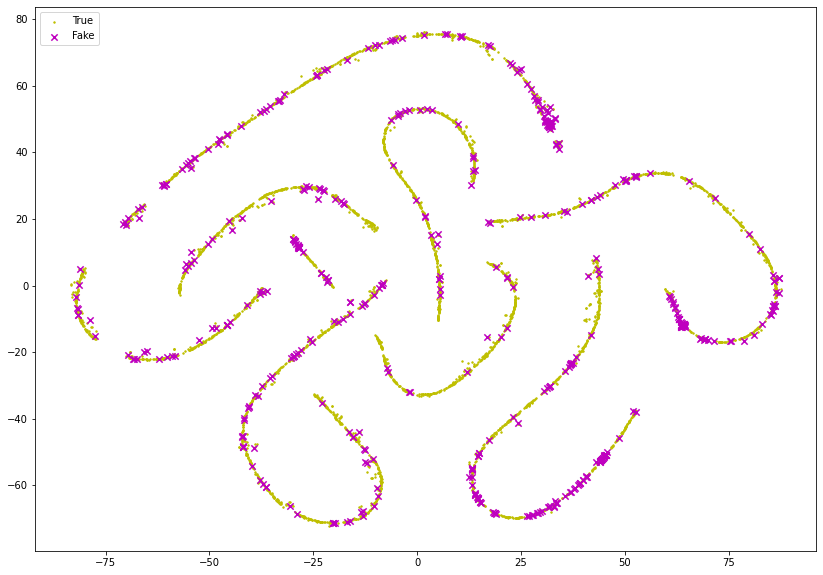

In [ ]:
fig, ax = plt.subplots(1, figsize=(14,10))
plt.scatter(result_tsne[idx_zero][:,1],result_tsne[idx_zero][:,0],s=2,marker='o',c='y')
plt.scatter(result_tsne[idx_one][:,1], result_tsne[idx_one][:,0],s=40,marker='x',c='m')
plt.legend(['True','Fake'],loc='upper left')
plt.show()  ##거의 모든 값들이 겹쳐져서 구별이 힘들다.

## AutoEncoder을 사용한 준지도학습

In [ ]:
x_normal=df[df['Class']==0].drop("Class",axis=1).values[:2843]
x_fraud=df[df['Class']==1].drop('Class',axis=1).values

REP_DIM=50

In [ ]:
x_normal.shape,x_fraud.shape

((2843, 30), (492, 30))

In [ ]:
def create_ae_model(input_shape):
    inputs = Input(shape=(input_shape,))
    
    encoded1 = Dense(100,activation='tanh', activity_regularizer=l1(10e-5), kernel_initializer='glorot_normal')(inputs)
    encoded2 = Dense(REP_DIM, activation='relu',kernel_initializer='he_normal')(encoded1)

    decoded1 = Dense(REP_DIM,activation='tanh',kernel_initializer='glorot_normal')(encoded2)
    decoded2 = Dense(100,activation='tanh',kernel_initializer='glorot_normal')(decoded1)

    ouputs = Dense(input_shape,activation='relu',kernel_initializer='he_normal')(decoded2)

    model = Model(inputs,ouputs)

    return model 

In [ ]:
ae_model = create_ae_model(x_normal.shape[1])
ae_model.compile(loss='mse',optimizer='adam')
ae_model.fit(x_normal,x_normal,batch_size=256,epochs=10,validation_split=0.2)

Epoch 1/10
9/9 [==============================] - 1s 31ms/step - loss: 36884.2742 - val_loss: 150656.6406
Epoch 2/10
9/9 [==============================] - 0s 8ms/step - loss: 36146.0270 - val_loss: 150106.3125
Epoch 3/10
9/9 [==============================] - 0s 7ms/step - loss: 35965.0191 - val_loss: 149641.0000
Epoch 4/10
9/9 [==============================] - 0s 7ms/step - loss: 35468.0027 - val_loss: 149284.8906
Epoch 5/10
9/9 [==============================] - 0s 7ms/step - loss: 35109.6070 - val_loss: 149021.0312
Epoch 6/10
9/9 [==============================] - 0s 8ms/step - loss: 34922.8023 - val_loss: 148808.0625
Epoch 7/10
9/9 [==============================] - 0s 7ms/step - loss: 34943.4316 - val_loss: 148620.7500
Epoch 8/10
9/9 [==============================] - 0s 7ms/step - loss: 36337.2383 - val_loss: 148446.2656
Epoch 9/10
9/9 [==============================] - 0s 7ms/step - loss: 35070.2691 - val_loss: 148280.4375
Epoch 10/10
9/9 [==============================] - 0s 

## AutoEncoder 에서 Encoder부분만 사용

In [ ]:
 ae_model.layers[0]

In [ ]:
def create_rep_model():
    inputs = ae_model.input
    encoded1 = ae_model.layers[1](inputs)
    encoded2 = ae_model.layers[2](encoded1)

    model = Model(inputs, encoded2)

    return model

rep_model = create_rep_model()

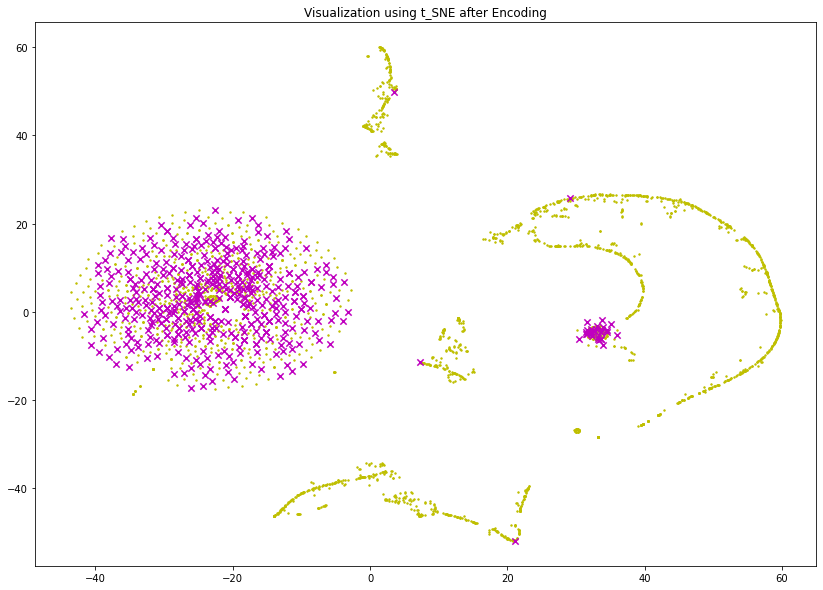

In [ ]:
normal_rep=rep_model.predict(x_normal)
fraud_rep=rep_model.predict(x_fraud)

x_rep=np.append(normal_rep,fraud_rep,axis=0)
y_normal = np.zeros(normal_rep.shape[0])
y_fraud = np.ones(fraud_rep.shape[0])
y_all = np.append(y_normal, y_fraud)

result_tsne = tsne.fit_transform(x_rep)

fig,ax = plt.subplots(1, figsize=(14,10))
plt.scatter(result_tsne[:len(y_normal)][:,1],result_tsne[:len(y_normal)][:,0],s=2, marker='o', c='y')
plt.scatter(result_tsne[len(y_normal):][:,1],result_tsne[len(y_normal):][:,0],s=40, marker='x', c='m')
plt.title("Visualization using t_SNE after Encoding")
plt.show() ##Encoding 하기 전 보다 구분이 잘되는 것을 확인할 수 있다.
